# Compilation of Model

This notebook must be ran inside the FINN docker image.

Enter the FINN repository and run:

`./run-docker.sh notebook`

First we want to load the PyTorch/Brevitas model

In [45]:
import torch

from neural_networks import Networks, ModelConfig

resource_directory = "resources/3-34/"
dataset_directory = "datasets/"
torch_model_path = resource_directory + "model.pth"

cfg = ModelConfig(
    "ESPCN",
    4,
    True,
    bit_width=4
)

# this is model-dependant
torch_model = Networks.get(cfg)
torch_model.load_state_dict(torch.load(torch_model_path))

<All keys matched successfully>

Then we can load the visualise onnx equivalent

In [46]:
# noinspection PyUnresolvedReferences
from finn.util.visualization import showInNetron

onnx_model_path = resource_directory + "model.onnx"
showInNetron(onnx_model_path)

Stopping http://0.0.0.0:8081
Serving 'resources/3-34/model.onnx' at http://0.0.0.0:8081


We next want to verify that the models behave the same, given the same input image

In [47]:
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as runner
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

loaded_image = Image.open(dataset_directory + "super-resolution/Set14/img_005_SRF_2_LR.png")
target = Image.open(dataset_directory + "super-resolution/Set14/img_005_SRF_2_HR.png")
input_tensor = np.array(loaded_image).astype(np.float32).transpose(2, 0, 1)[np.newaxis, ...] / 255.0
target_tensor = np.array(loaded_image).astype(np.float32).transpose(2, 0, 1)[np.newaxis, ...] / 255.0

onnx_model = ModelWrapper(onnx_model_path)
input_dict = { "global_in" : input_tensor }
output_dict = runner.execute_onnx(onnx_model, input_dict)
produced_qonnx = output_dict[list(output_dict.keys())[0]]


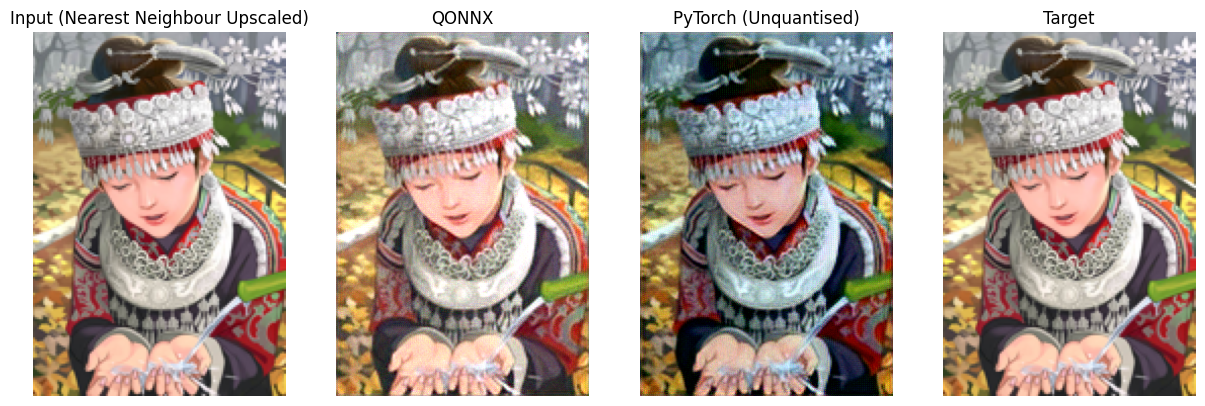

In [48]:
torch_output = torch_model(torch.tensor(input_tensor)).detach().cpu().numpy()

original_image = np.transpose(input_tensor[0], (1, 2, 0))
numpy_image = np.transpose(produced_qonnx[0], (1, 2, 0))
torch_image = np.transpose(torch_output[0], (1, 2, 0))
target_image = np.transpose(target_tensor[0], (1, 2, 0))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

titles = ["Input (Nearest Neighbour Upscaled)", "QONNX", "PyTorch (Unquantised)", "Target"]

for index, image in enumerate([original_image, numpy_image, torch_image, target_image]):
    axes[index].imshow(image)
    axes[index].axis('off')
    axes[index].set_title(titles[index])

plt.show()

## QONNX to FINN-ONNX

The FINN compiler infrastructure internally uses the custom FINN-ONNX representation. There is functionality provided to help us convert from QONNX to FINN-ONNX

In [49]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from finn.util.pytorch import ToTensor

from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

onnx_model = onnx_model.transform(ConvertQONNXtoFINN())
onnx_model = onnx_model.transform(InferShapes())
onnx_model = onnx_model.transform(FoldConstants())
onnx_model = onnx_model.transform(GiveUniqueNodeNames())
onnx_model = onnx_model.transform(GiveReadableTensorNames())
onnx_model = onnx_model.transform(RemoveStaticGraphInputs())

export_finn_onnx_path = resource_directory + "finn_model.onnx"
onnx_model.save(export_finn_onnx_path)

showInNetron(export_finn_onnx_path)

Stopping http://0.0.0.0:8081
Serving 'resources/3-34/finn_model.onnx' at http://0.0.0.0:8081


### Image: UInt8 -> Float32

We now need to bake in a division by 255 operation, as that's what PyTorch's `ToTensor()` transformation does

In [50]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

# load model we just saved
finn_model = ModelWrapper(export_finn_onnx_path)

# bake in some preprocessing to mirror the functionality of PyTorch's toTensor() transformation
input_node_name = finn_model.graph.input[0].name
input_shape = finn_model.get_tensor_shape(input_node_name)
div_255 = ToTensor()

temp_file = resource_directory + "preprocessing.onnx"
export_qonnx(ToTensor(), torch.randn(input_shape), temp_file)
cleanup(temp_file, out_file=temp_file)

preprocessing_model = ModelWrapper(temp_file)
preprocessing_model = preprocessing_model.transform(ConvertQONNXtoFINN())

finn_model = finn_model.transform(MergeONNXModels(preprocessing_model))

# tell FINN that the input expected should be UINT8
global_input_name = finn_model.graph.input[0].name
finn_model.set_tensor_datatype(global_input_name, DataType["UINT8"])

/home/jakedves/Documents/finn-new/deps/qonnx/src/qonnx/transformation/merge_onnx_models.py:70: UserWarning: [MergeONNXModels] opsets for models to merge differ: 14 vs 17, output model will use opset 17
  warnings.warn(
/home/jakedves/Documents/finn-new/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


We will then infer the remaining datatypes, and process our model again

In [51]:
from qonnx.transformation.infer_datatypes import InferDataTypes

finn_model = finn_model.transform(InferShapes())
finn_model = finn_model.transform(FoldConstants())
finn_model = finn_model.transform(GiveUniqueNodeNames())
finn_model = finn_model.transform(GiveReadableTensorNames())
finn_model = finn_model.transform(InferDataTypes())
finn_model = finn_model.transform(RemoveStaticGraphInputs())
finn_model.save(export_finn_onnx_path)

showInNetron(export_finn_onnx_path)

Stopping http://0.0.0.0:8081
Serving 'resources/3-34/finn_model.onnx' at http://0.0.0.0:8081


## Verification

The transformations may not work across all models, so verify that our FINN-ONNX model produces the same (or very similar) outputs, given the same input

In [54]:
finn_model = ModelWrapper(export_finn_onnx_path)
finn_input_tensor = np.array(loaded_image).astype(np.float32).transpose(2, 0, 1)[np.newaxis, ...]

input_dict = { "global_in" : finn_input_tensor }
output_dict = runner.execute_onnx(finn_model, input_dict)
produced_finn = output_dict[list(output_dict.keys())[0]]

# verify that the behaviour is still the same
print(np.isclose(produced_finn, produced_qonnx))

[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]]


# Network Preparation

We can then start applying optimisation transformations

In [55]:
# noinspection PyUnresolvedReferences
from finn.transformation.streamline import Streamline

# noinspection PyUnresolvedReferences
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants

# noinspection PyUnresolvedReferences
import finn.transformation.streamline.absorb as absorb

from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors


finn_model = ModelWrapper(export_finn_onnx_path)
finn_model = finn_model.transform(MoveScalarLinearPastInvariants())
finn_model = finn_model.transform(Streamline())
finn_model = finn_model.transform(LowerConvsToMatMul())
finn_model = finn_model.transform(MakeMaxPoolNHWC())
finn_model = finn_model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
finn_model = finn_model.transform(ConvertBipolarMatMulToXnorPopcount())
finn_model = finn_model.transform(Streamline())
finn_model = finn_model.transform(InferDataLayouts())
finn_model = finn_model.transform(RemoveUnusedTensors())
finn_model.save(export_finn_onnx_path)

showInNetron(export_finn_onnx_path)

Stopping http://0.0.0.0:8081
Serving 'resources/3-34/finn_model.onnx' at http://0.0.0.0:8081


Probably a good time to verify that behaviour is as expected...

In [56]:
finn_model = ModelWrapper(export_finn_onnx_path)

input_dict = { "global_in" : finn_input_tensor }
output_dict = runner.execute_onnx(finn_model, input_dict)
produced_finn = output_dict[list(output_dict.keys())[0]]

np.isclose(produced_finn, produced_qonnx)

/home/jakedves/Documents/finn-new/deps/qonnx/src/qonnx/util/basic.py:296: UserWarning: The values of tensor MultiThreshold_0_param0 can't be represented with the set datatype annotation (UINT8), they will be rounded to match the datatype annotation.
  warnings.warn(


[[[[0.3921569  0.1137255  0.52156866 ... 0.61960787 0.29411766
    0.6784314 ]
   [0.25882354 0.45098042 0.7254902  ... 0.62352943 0.5529412
    0.36862746]
   [0.54509807 0.5294118  0.627451   ... 0.69803923 0.5882353
    0.6       ]
   ...
   [0.47058827 0.59607846 0.62352943 ... 0.8352942  0.854902
    0.49411768]
   [0.4784314  0.64705884 0.67058825 ... 0.5921569  0.3372549
    0.35686275]
   [0.6117647  0.4901961  0.6627451  ... 0.43921572 0.427451
    0.28235295]]

  [[0.29411766 0.4784314  0.47450984 ... 0.4901961  0.4431373
    0.32941177]
   [0.44705886 0.3647059  0.5764706  ... 0.56078434 0.454902
    0.37647063]
   [0.6666667  0.6745098  0.6784314  ... 0.54509807 0.6431373
    0.53333336]
   ...
   [0.47450984 0.32941177 0.5411765  ... 0.6745098  0.5411765
    0.6431373 ]
   [0.3803922  0.3529412  0.57254905 ... 0.38431376 0.43529415
    0.34901962]
   [0.36078432 0.3647059  0.47058827 ... 0.3137255  0.35686275
    0.41960788]]

  [[0.42352945 0.43137258 0.48235297 ... 0.607

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

The model can then be converted into "hardware layers" that can be directly mapped to an FPGA

In [57]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.infer_data_layouts import InferDataLayouts

model = ModelWrapper(export_finn_onnx_path)
model = model.transform(to_hw.InferBinaryMatrixVectorActivation())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())

# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())
model = model.transform(to_hw.InferConvInpGen())
model = model.transform(to_hw.InferStreamingMaxPool())

# get rid of Reshape(-1, 1) operation between hw nodes
model = model.transform(RemoveCNVtoFCFlatten())

# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())

# infer tensor data layouts
model = model.transform(InferDataLayouts())
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(resource_directory + "dataflow_parent.onnx")

sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")

# save the dataflow partition with a different name for easier access
# and specialize the layers to HLS variants
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model = dataflow_model.transform(SpecializeLayers())

exported_dataflow_filename = resource_directory + "dataflow_model.onnx"
dataflow_model.save(exported_dataflow_filename)

showInNetron(exported_dataflow_filename)

Stopping http://0.0.0.0:8081
Serving 'resources/3-34/dataflow_model.onnx' at http://0.0.0.0:8081


At this point, we can adjust the folding factors of our network in order to change performance, lookup table usage, and so on

In [60]:
fully_connected_layers = dataflow_model.get_nodes_by_op_type("MVAU_hls")
print(len(fully_connected_layers))

sliding_window_layers = dataflow_model.get_nodes_by_op_type("ConvolutionInputGenerator_rtl")
print(len(sliding_window_layers))

3
4


In [ ]:
# each tuple is (PE, SIMD, in_fifo_depth) for a layer
folding = [
    (16, 3, [128]),
    (32, 32, [128]),
    (16, 32, [128]),
    (32, 32, [128])
]

for fcl, (pe, simd, ififodepth) in zip(fully_connected_layers), folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififodepth)

# use same SIMD values for the sliding window operators
for i in range(len(sliding_window_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)